## Feature Extraction

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('Price.csv')

In [29]:
#Renaming title of columns
df = df.rename(columns ={'कृषि उपज':'Name','ईकाइ':'Quantity','न्यूनतम':'Min','अधिकतम':'Max','औसत':'Avg'})

#Converting column containing nepali numbers into int
df['Avg']=df['Avg'].apply(lambda x: int(x))

In [30]:
#Converting date column to date
import datetime
df['cdate']=pd.to_datetime(df['cdate'])
print(df.dtypes)      #Data types of the columns in df

Name                 object
Quantity             object
Min                  object
Max                  object
Avg                   int64
cdate        datetime64[ns]
pricetype            object
dtype: object


In [31]:
df['Name'].value_counts()

मूला सेतो(लोकल)    1436
काउली स्थानिय      1436
भुर्इ कटहर         1436
बन्दा(लोकल)        1436
अदुवा              1436
                   ... 
अम्बा                44
सजिवन                32
अंगुर(कालो)          32
लीच्ची(भारतीय)       28
परवर(तराई)           16
Name: Name, Length: 120, dtype: int64

In [32]:
df.head(10)

,Name,Quantity,Min,Max,Avg,cdate,pricetype
0,गोलभेडा ठूलो(नेपाली),के.जी.,३०,३५,33,2018-02-25,W
1,गोलभेडा सानो,के.जी.,२५,३०,28,2018-02-25,W
2,अालु रातो,के.जी.,२०,२३,22,2018-02-25,W
3,अालु सेतो,के.जी.,१८,२०,19,2018-02-25,W
4,प्याज सुकेको भारतीय,के.जी.,४४,४६,45,2018-02-25,W
5,गाजर(लोकल),के.जी.,२५,३०,28,2018-02-25,W
6,बन्दा(लोकल),के.जी.,२२,२८,25,2018-02-25,W
7,काउली स्थानिय,के.जी.,२५,३०,28,2018-02-25,W
8,काउली तरार्इ,के.जी.,२०,२५,23,2018-02-25,W
9,मूला रातो,के.जी.,३०,३५,33,2018-02-25,W


### Adding two features: 
#### Price of yesterday and the day before yesterday

In [33]:
vegetable = set(df['Name'].values)      #Creating a set of vegetable i.e taking all the unique vegetables
len(vegetable)

feature_df = []                         # Empty list for future use

for v in vegetable:
    for p_type in ['W','R']:

        df_v = df[(df['Name'] == v) & (df['pricetype']== p_type)] #taking a vegetable of only one pricetype
        df_v = df_v.sort_values(by = ['cdate'], ascending = False) #sorting in descending order based on date. Recent date will be at first.

        if p_type == 'W':
            df_v['type'] = 1
        else:
            df_v['type'] = 0


        df_v['t_1'] = df_v.shift(-1)['Avg']
        df_v['t_2'] = df_v.shift(-2)['Avg']
#         df_v['t_7'] = df_v.shift(-7)['Avg']     #Could be a feature but data size decreases drastically

        feature_df.append(df_v)


In [34]:
feature_df = pd.concat(feature_df)

In [35]:
feature_df.dropna(inplace=True)
feature_df.tail()

,Name,Quantity,Min,Max,Avg,cdate,pricetype,type,t_1,t_2
3733,सजिवन,के.जी.,२१०,२२०,215,2018-03-25,R,0,215.0,215.0
3592,सजिवन,के.जी.,२१०,२२०,215,2018-03-24,R,0,215.0,215.0
3450,सजिवन,के.जी.,२१०,२२०,215,2018-03-23,R,0,215.0,215.0
3308,सजिवन,के.जी.,२१०,२२०,215,2018-03-22,R,0,215.0,215.0
3168,सजिवन,के.जी.,२१०,२२०,215,2018-03-21,R,0,215.0,125.0


In [36]:
feature_df = feature_df.sample(frac = 1, random_state= 1)

In [37]:
X = feature_df[['type','t_1', 't_2']].values #getting feature matrix
X

array([[ 1., 38., 36.],
       [ 0., 85., 85.],
       [ 0., 55., 55.],
       ...,
       [ 1., 33., 33.],
       [ 0., 45., 45.],
       [ 1., 85., 75.]])

In [38]:
X.shape

(98822, 3)

In [39]:
X = np.insert(X, 0, values=1, axis = 1) #adding bias or intercept term
X

array([[ 1.,  1., 38., 36.],
       [ 1.,  0., 85., 85.],
       [ 1.,  0., 55., 55.],
       ...,
       [ 1.,  1., 33., 33.],
       [ 1.,  0., 45., 45.],
       [ 1.,  1., 85., 75.]])

In [40]:
y = feature_df['Avg'].values
print(y.shape)

(98822,)


## Dividing into train, test and validation datas

### 60% Train 20% Validation and Test each

In [41]:
total = len(X)
train = int(0.6 * total)
val = int(0.2*total)

X_train = X[:train]
y_train = y[:train].reshape(-1,1)

X_val = X[train:train + val]
y_val = y[train:train +val].reshape(-1,1)

X_test = X[train + val:]
y_test = y[train + val:].reshape(-1,1)

print(len(X_train), len(X_val),len(X_test))

59293 19764 19765


### Normalization
####  Min-max

In [42]:
#To cope with convergence problem during gradient descent, we take all our features into same range. 
X_train 

array([[  1.,   1.,  38.,  36.],
       [  1.,   0.,  85.,  85.],
       [  1.,   0.,  55.,  55.],
       ...,
       [  1.,   0.,  45.,  45.],
       [  1.,   0., 155., 155.],
       [  1.,   0.,  75.,  75.]])

In [43]:
price_X = X_train[:, 1:]

min_v = np.min(price_X)
max_v = np.max(price_X)
diff = max_v - min_v

In [44]:
price_X

array([[  1.,  38.,  36.],
       [  0.,  85.,  85.],
       [  0.,  55.,  55.],
       ...,
       [  0.,  45.,  45.],
       [  0., 155., 155.],
       [  0.,  75.,  75.]])

In [45]:
def min_max_normalization(dataset):
    for i in range(0, dataset.shape[0]):
        for j in range(0, dataset.shape[1]):
            dataset[i][j] = (dataset[i][j]-min_v)/diff

min_max_normalization(X_train)
min_max_normalization(X_val)
min_max_normalization(X_test)

In [46]:
X_train

array([[0.00061538, 0.00061538, 0.02338462, 0.02215385],
       [0.00061538, 0.        , 0.05230769, 0.05230769],
       [0.00061538, 0.        , 0.03384615, 0.03384615],
       ...,
       [0.00061538, 0.        , 0.02769231, 0.02769231],
       [0.00061538, 0.        , 0.09538462, 0.09538462],
       [0.00061538, 0.        , 0.04615385, 0.04615385]])

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(59293, 4)
(59293, 1)
(19764, 4)
(19764, 1)
(19765, 4)
(19765, 1)


### Hyperparameter Tuning

In [62]:
np.random.seed(42)
#HyperParameter
#Beautify Code by creating dictionary containing all hyperparameters

train_error=[]

param={
    'num_of_iteration':1000,
    'learning_rate':0.1,
    'regularization':0.1
}

grid_param={
    'num_of_iteration':[2000,5000],
    'learning_rate':[0.1,0.9],
    'regularization':[0.1,0.01,0.001]
}

def MSE(h,y):
    return 0.5*np.average((h-y)**2)


In [63]:
#Now a grid is to be created which contains the combination of num_of_iteration and learning_rate. 
#Hyper Parameter Tuning
#This combination is fed to the function and the combination with the best result is our final value of hyperparameters

import itertools
grid=list(itertools.product(grid_param['num_of_iteration'],grid_param['learning_rate'],grid_param['regularization']))
print(grid)

for g in grid:
    p={
    'num_of_iteration':g[0],
    'learning_rate':g[1],
    'regularization':g[2],
    }

[(2000, 0.1, 0.1), (2000, 0.1, 0.01), (2000, 0.1, 0.001), (2000, 0.9, 0.1), (2000, 0.9, 0.01), (2000, 0.9, 0.001), (5000, 0.1, 0.1), (5000, 0.1, 0.01), (5000, 0.1, 0.001), (5000, 0.9, 0.1), (5000, 0.9, 0.01), (5000, 0.9, 0.001)]


In [68]:
def train_model(X_train,y_train,X_val,y_val,param):
    np.random.seed(42)
    W=np.random.rand(X_train.shape[1]).reshape(-1,1)    #We reshape the row vector(1*4) to column vector(4*1)
    
    train_error=[]
    val_error=[]
    

    #Run the loop num_of_iteration times 
    for i in range(1,param['num_of_iteration']):
        h_train=np.matmul(X_train,W)        #h_train is matrix mul of X_train and W
        R=param['regularization']*sum(W**2) 
        train_loss=MSE(h_train,y_train)+R   #loss in training data is calculated by calling MSE function
        train_error.append(train_loss)      
        
        #Gradient-- Code form of the formula. shape[0] gives the number of rows
        gradient_main=(np.matmul(np.transpose(h_train-y_train),X_train)/X_train.shape[0]).reshape(-1,1)   
        
        #Regularized Gradient
        gradient_reg=2*param['regularization']*W
#         print(gradient_main.shape)
        gradient_reg[0]=0
        gradient=gradient_main+gradient_reg
        
        #W is the updated weight
#         W=W-param['learning_rate']*gradient
        W=W-param['learning_rate']*gradient
    
    #Once training is done. We have to use Val set to tune hyper parameter. 
    #The p(combination) that gives least error is our final value for hyperparameters.
    h_val=np.matmul(X_val,W)
    val_loss=MSE(h_val,y_val)
    val_error.append(val_loss)
    return W, train_error, val_error
# Weights, train_error, val_error = train_model(X_train,y_train,X_val,y_val,p)         


In [69]:
Weights,train_error,val_error=train_model(X_train,y_train,X_val,y_val,param)

{'num_of_iteration': 2000, 'learning_rate': 0.1, 'regularization': 0.1}
[7669.9212373703085]


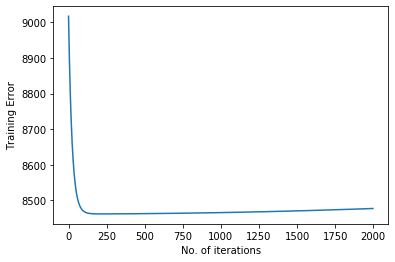

{'num_of_iteration': 2000, 'learning_rate': 0.1, 'regularization': 0.01}
[3161.5807675813626]


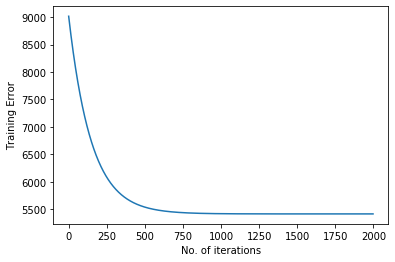

{'num_of_iteration': 2000, 'learning_rate': 0.1, 'regularization': 0.001}
[347.6946333162724]


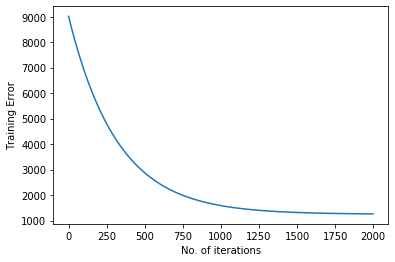

{'num_of_iteration': 2000, 'learning_rate': 0.9, 'regularization': 0.1}
[7664.227432227719]


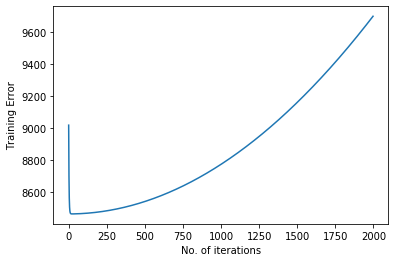

{'num_of_iteration': 2000, 'learning_rate': 0.9, 'regularization': 0.01}
[3155.1312780160183]


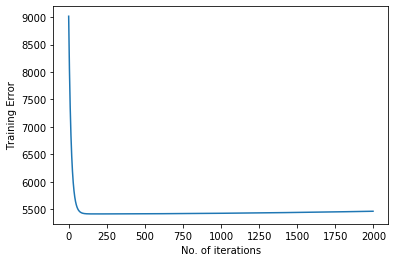

{'num_of_iteration': 2000, 'learning_rate': 0.9, 'regularization': 0.001}
[251.42768895625164]


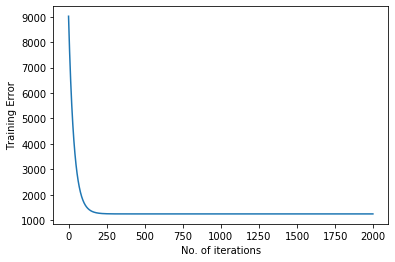

{'num_of_iteration': 5000, 'learning_rate': 0.1, 'regularization': 0.1}
[7668.852603484854]


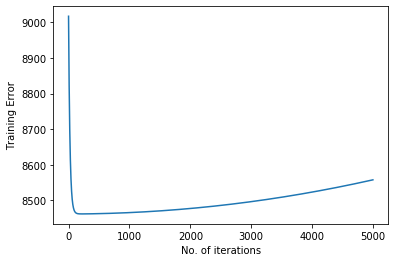

{'num_of_iteration': 5000, 'learning_rate': 0.1, 'regularization': 0.01}
[3156.34960679901]


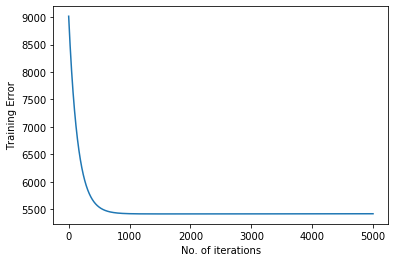

{'num_of_iteration': 5000, 'learning_rate': 0.1, 'regularization': 0.001}
[252.27511892236998]


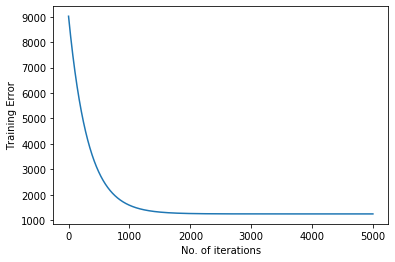

{'num_of_iteration': 5000, 'learning_rate': 0.9, 'regularization': 0.1}
[7654.629549355428]


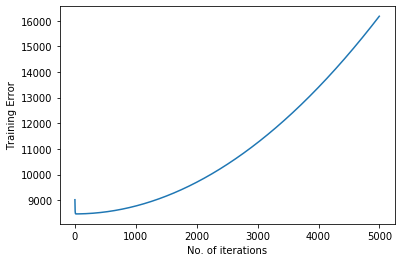

{'num_of_iteration': 5000, 'learning_rate': 0.9, 'regularization': 0.01}
[3152.6030437755508]


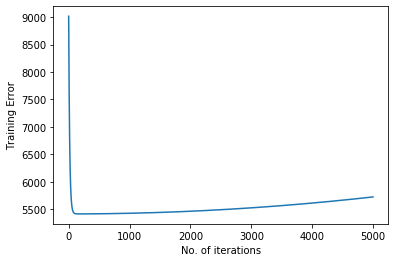

{'num_of_iteration': 5000, 'learning_rate': 0.9, 'regularization': 0.001}
[251.38499071145137]


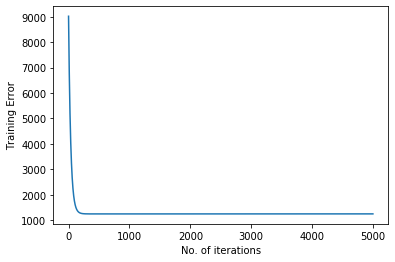

In [110]:
for g in grid:
    p={
    'num_of_iteration':g[0],
    'learning_rate':g[1],
    'regularization':g[2]
    }
    print(p)
    Weights,train_error,val_error=train_model(X_train,y_train,X_val,y_val,p)
    print(val_error)
    plt.plot(np.arange(len(train_error)),train_error)
    plt.xlabel("No. of iterations")
    plt.ylabel("Training Error")   
    plt.show()

In [ ]:
# def grid_search(X_train,y_train,X_val,y_val,grid_param):
#     grid=list(itertools(product))

### Model Evaluation with R2 Score

In [109]:
final_param = {'num_of_iteration': 5000, 'learning_rate': 0.1, 'regularization': 0.001}
model_weights =  train_model(X_train,y_train,X_val,y_val,final_param) #Returns Weight, train_error and validation error


In [104]:
#Select weight only as
model_weights=model_weights[0]

In [105]:
# model_weights=model_weights[:4]
model_weights

array([[ 43.06863221],
       [  1.94835727],
       [714.33249749],
       [697.40929342]])

In [106]:
y_mean = np.mean(y_test)
h_test = np.matmul(X_test, model_weights)
n = X_test.shape[0]
k = X_test.shape[1] - 1
SST = np.sum(np.square(y_test - y_mean))
SSR = np.sum(np.square(h_test- y_mean))
SSE = SST - SSR
print(SSE)
R2 = 1 - (SSE/(n-k-1))/(SST/(n-1))
R2

30980276.58839631


0.769081755631585

In [107]:
X_test.shape,model_weights.shape,h_test.shape

((19765, 4), (4, 1), (19765, 1))

In [108]:
sse = np.sum(np.square(h_test - y_test))
sse

10275063.558307843

In [170]:
# #5000 and 0.1
# SSE= 1100482.76069282

# R2= 0.9912581329676198

# sse= 4699303.15028573